In [ ]:
#Setup & Reproducibility
import random, os, numpy as np
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

!pip -q install nltk spacy seaborn matplotlib

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger_eng')

import spacy
spacy.util.fix_random_seed(42)



nltk.data.path.append('/root/nltk_data')
!python -m spacy download es_core_news_sm > /dev/null



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
#Load Dataset
import pandas as pd

URL = "https://raw.githubusercontent.com/Eman-Nasr/multilingual-movie-reviews/main/multilingual_reviews_cleaned.csv"
df = pd.read_csv(URL)
print("Columns:", df.columns.tolist())
df.head(3)

Columns: ['review_en', 'review_en_clean', 'review_en_tokens', 'sentiment', 'review_en_wordcount', 'review_es', 'review_es_clean', 'review_es_tokens', 'review_es_wordcount', 'sentimiento']


,review_en,review_en_clean,review_en_tokens,sentiment,review_en_wordcount,review_es,review_es_clean,review_es_tokens,review_es_wordcount,sentimiento
0,"this is the 1990s TV show,not the movie from 1...",tv shownot movie look three episode total minu...,"['tv', 'shownot', 'movie', 'look', 'three', 'e...",negative,68,Este es el programa de televisión de la década...,programa televisión década película parece tr ...,"['programa', 'televisión', 'década', 'película...",67,negativo
1,I dont see much reason to get into this movie ...,dont see much reason get movie much detail syl...,"['dont', 'see', 'much', 'reason', 'get', 'movi...",negative,278,No veo mucha razón para entrar en esta películ...,veo mucha razón entrar película detalle sylves...,"['veo', 'mucha', 'razón', 'entrar', 'película'...",290,negativo
2,"I looked at this movie with my child eyes, and...",look movie child eye wasnt disappoint story we...,"['look', 'movie', 'child', 'eye', 'wasnt', 'di...",positive,41,"Miré esta película con los ojos de mi hijo, y ...",miré película oj hijo decepcionóla historia co...,"['miré', 'película', 'oj', 'hijo', 'decepcionó...",40,positivo


In [ ]:
#Normalize to Long Format
def to_long(df):
    """Convert bilingual wide-format dataset into long format with columns: language, review, sentiment."""
    if {'review_en','review_es'}.issubset(df.columns):
        en = pd.DataFrame({'language':'English', 'review':df['review_en'], 'sentiment':df.get('sentiment')})
        es = pd.DataFrame({'language':'Spanish', 'review':df['review_es'], 'sentiment':df.get('sentimiento')})
        return pd.concat([en, es], ignore_index=True).dropna(subset=['review'])
    elif {'language','review'}.issubset(df.columns):
        return df[['language','review','sentiment']]
    else:
        df['language'] = 'English'
        return df[['language','review','sentiment']] if 'sentiment' in df.columns else df[['language','review']]

dfl = to_long(df)
print(dfl['language'].value_counts())
dfl.head(3)


language
English    1500
Spanish    1500
Name: count, dtype: int64


,language,review,sentiment
0,English,"this is the 1990s TV show,not the movie from 1...",negative
1,English,I dont see much reason to get into this movie ...,negative
2,English,"I looked at this movie with my child eyes, and...",positive


In [ ]:
#Text Cleaning & Tokenization
import re, string, unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_en = set(stopwords.words('english'))
stop_es = set(stopwords.words('spanish'))

def clean_and_tokenize(text, lang):
    """Lowercase, remove punctuation, stopwords, accents, and tokenize."""
    t = str(text).lower()
    t = re.sub(r'http\S+|www\S+', '', t)
    t = re.sub(r'<.*?>', '', t)
    t = t.translate(str.maketrans('', '', string.punctuation))
    t = re.sub(r'\d+', '', t)
    t = unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8')
    toks = word_tokenize(t, language='english')
    sw = stop_en if lang == 'English' else stop_es
    toks = [w for w in toks if w not in sw and len(w) > 1]
    return toks

dfl['tokens'] = [clean_and_tokenize(r, l) for r, l in zip(dfl['review'], dfl['language'])]
dfl['word_count'] = dfl['tokens'].apply(len)
dfl.groupby('language')['word_count'].describe()[['mean','min','max']]


,mean,min,max
language,,,
English,118.335333,10.0,619.0
Spanish,131.354667,9.0,1208.0


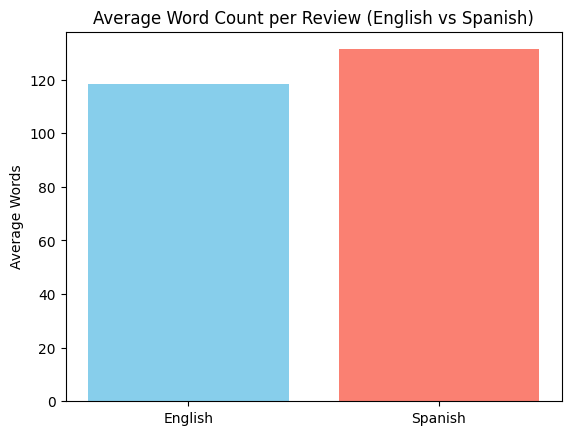

In [ ]:
#Visualization Word Count by Language
import matplotlib.pyplot as plt

avg_wc = dfl.groupby('language')['word_count'].mean().sort_values()
plt.bar(avg_wc.index, avg_wc.values, color=['skyblue','salmon'])
plt.title('Average Word Count per Review (English vs Spanish)')
plt.ylabel('Average Words')
plt.show()


In [ ]:
#N-gram Language Models & Perplexity
from collections import Counter
import math

def ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def build_lm(docs, n=1):
    """Build n-gram model with counts."""
    counts_n, counts_n1 = Counter(), Counter()
    vocab = set()
    for toks in docs:
        vocab.update(toks)
        counts_n.update(ngrams(toks, n))
        if n > 1:
            counts_n1.update(ngrams(toks, n-1))
    return counts_n, counts_n1, vocab

def perplexity(counts_n, counts_n1, vocab, test_tokens, n=1):
    """Compute Add-1 (Laplace) smoothed perplexity."""
    V = len(vocab)
    N = len(test_tokens)
    logprob = 0.0
    for i in range(n-1, N):
        hist = tuple(test_tokens[i-n+1:i]) if n > 1 else ()
        w = tuple(test_tokens[i-n+1:i+1])
        num = counts_n[w] + 1
        den = (counts_n1[hist] if n > 1 else sum(counts_n.values())) + V
        logprob += -math.log(num/den)
    return math.exp(logprob / max(1, N))

results = []
for lang in ['English','Spanish']:
    docs = dfl[dfl['language']==lang]['tokens'].tolist()
    split = int(0.9 * len(docs))
    train, test = docs[:split], docs[split:]
    test_tokens = [t for d in test for t in d]
    for n in [1,2,3]:
        c_n, c_n1, vocab = build_lm(train, n)
        ppl = perplexity(c_n, c_n1, vocab, test_tokens, n)
        results.append((lang, n, round(ppl,2)))

perp_df = pd.DataFrame(results, columns=['Language','n','Perplexity'])
perp_df.pivot(index='Language', columns='n', values='Perplexity')


n,1,2,3
Language,,,
English,5930.26,19222.45,24428.78
Spanish,7395.34,22742.39,31425.68


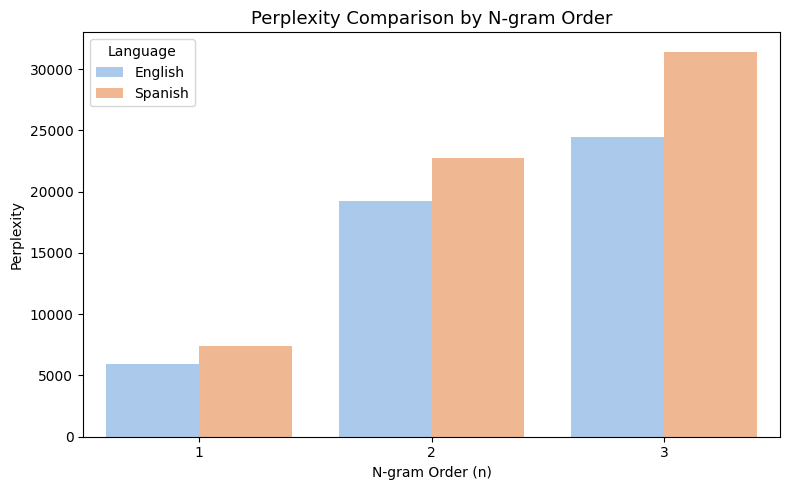

In [ ]:
#Perplexity Comparison Chart
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(x='n', y='Perplexity', hue='Language', data=perp_df, palette='pastel')
plt.title('Perplexity Comparison by N-gram Order', fontsize=13)
plt.xlabel('N-gram Order (n)')
plt.ylabel('Perplexity')
plt.legend(title='Language')
plt.tight_layout()
plt.show()



In [ ]:
# POS Tagging Baseline
import nltk
import spacy
import pandas as pd

nlp_es = spacy.load('es_core_news_sm')

def pos_tag_en(tokens):
    return nltk.pos_tag(tokens, tagset='universal')

def pos_tag_es(tokens):
    doc = nlp_es(' '.join(tokens))
    return [(t.text, t.pos_) for t in doc]

dfl['pos_tags'] = dfl.apply(
    lambda row: pos_tag_en(row.tokens) if row.language == 'English' else pos_tag_es(row.tokens),
    axis=1
)

for lang in ['English', 'Spanish']:
    print(f"\nSample for {lang}:")
    print(dfl[dfl.language == lang][['language', 'pos_tags']].head(2))


print("\nRandom sample:")
print(dfl[['language', 'pos_tags']].sample(5, random_state=42))



Sample for English:
  language                                           pos_tags
0  English  [(tv, NOUN), (shownot, NOUN), (movie, NOUN), (...
1  English  [(dont, NOUN), (see, VERB), (much, ADJ), (reas...

Sample for Spanish:
     language                                           pos_tags
1500  Spanish  [(programa, NOUN), (television, PROPN), (decad...
1501  Spanish  [(veo, VERB), (mucha, DET), (razon, ADJ), (ent...

Random sample:
     language                                           pos_tags
1801  Spanish  [(pelicula, VERB), (realmente, ADV), (buenala,...
1190  English  [(concur, NOUN), (everyone, NOUN), (said, VERB...
1817  Spanish  [(sorprendio, NOUN), (actuacion, PROPN), (temp...
251   English  [(first, ADV), (believe, VERB), (movie, NOUN),...
2505  Spanish  [(gracia, NOUN), (salvadora, ADJ), (pelicula, ...


In [ ]:
# POS Tag Frequency Distribution for Both Languages
from collections import Counter
import pandas as pd

def pos_counter(lang):
    tags = [tag for row in dfl[dfl.language == lang]['pos_tags'] for (_, tag) in row]
    return Counter(tags)

pos_en = pos_counter("English")
pos_es = pos_counter("Spanish")

pos_df = pd.DataFrame([pos_en, pos_es], index=["English", "Spanish"]).fillna(0).astype(int)
print("POS Tag Frequency Distribution:")
display(pos_df.style.background_gradient(cmap="Oranges"))


POS Tag Frequency Distribution:


,NOUN,VERB,NUM,ADJ,ADV,ADP,X,PRON,DET,CONJ,PRT,.,PROPN,SCONJ,AUX,CCONJ,INTJ,PART,PUNCT
English,77790,39327,2322,36865,15885,3736,262,359,602,175,178,2,0,0,0,0,0,0,0
Spanish,46278,35107,1202,46568,13510,1693,1,1014,3159,0,0,0,42553,1812,3907,178,27,12,12


In [ ]:
# Parsing (Chunking)
import nltk
import spacy
from nltk import RegexpParser

nlp_es = spacy.load('es_core_news_sm')

# Define grammar for noun phrases
grammar = r"NP: {<DET|PRON|ADJ|NOUN|PROPN>+}"
chunker = RegexpParser(grammar)

def chunk_sentence_en(tokens):
    pos = nltk.pos_tag(tokens, tagset='universal')
    tree = chunker.parse(pos)
    return '\n'.join(str(tree).split())

def chunk_sentence_es(tokens):
    doc = nlp_es(' '.join(tokens))
    return ' '.join([f"(NP {chunk.text})" for chunk in doc.noun_chunks])

# Apply chunking to dataset
dfl['chunks'] = dfl.apply(
    lambda row: chunk_sentence_en(row.tokens) if row.language == 'English'
    else chunk_sentence_es(row.tokens),
    axis=1
)

print(dfl[['language', 'chunks']].sample(5, random_state=42))


     language                                             chunks
1801  Spanish  (NP realmente buenala parcela) (NP sucedera co...
1190  English  (S\n(NP\nconcur/NOUN\neveryone/NOUN)\nsaid/VER...
1817  Spanish  (NP sorprendio actuacion temprana clint eastwo...
251   English  (S\nfirst/ADV\nbelieve/VERB\n(NP\nmovie/NOUN)\...
2505  Spanish  (NP gracia salvadora) (NP humor) (NP fortaleza...


In [ ]:
# Parsing Error Analysis: Inspect Incorrect or Fragmented Chunks
sample_errors = dfl.sample(5, random_state=10)

for i, row in sample_errors.iterrows():
    print("\n--- Example", i, "---")
    print("Language:", row.language)
    print("Original Review:", ' '.join(row.tokens)[:150], "...")
    print("Chunks Output:\n", row.chunks[:200], "...")



--- Example 1779 ---
Language: Spanish
Original Review: muchas cosas mal peliculajeff bridges weird accentritas purabilidad descifrar codigo contrasena script finalizacion esp ultima escena llevan dos cafes ...
Chunks Output:
 (NP muchas cosas) (NP bridges) (NP weird accentritas purabilidad descifrar codigo contrasena script finalizacion) (NP esp) (NP ultima escena) (NP dos cafes mesa) (NP rie) (NP camarero) (NP cafe) ...

--- Example 341 ---
Language: English
Original Review: set second year french republic formed execution louis xvi film portrays power struggle revolutionary leaders danton gerard depardieu finest robespier ...
Chunks Output:
 (S
set/VERB
(NP
second/ADJ
year/NOUN
french/ADJ
republic/NOUN)
formed/VERB
(NP
execution/NOUN
louis/NOUN
xvi/NOUN
film/NOUN
portrays/NOUN
power/NOUN
struggle/NOUN
revolutionary/ADJ
leaders/NOUN)
danto ...

--- Example 1276 ---
Language: English
Original Review: recall family made point stay home night nichols mondays tuesdays nbc superb vehicle

**Short Academic Observation — Chunking**

The noun phrase chunker successfully identifies many core NP groups in both English and Spanish text. However, errors are frequently observed in multi-word constructs. In English examples, NP boundaries sometimes include verbs (e.g., “convincingset/VERB”), indicating that the rule-based grammar does not always stop at lexical heads. In Spanish, SpaCy occasionally merges descriptive fragments into oversized chunks (e.g., combining adjectives, nouns, and unknown tokens), reflecting structural differences in Spanish NP syntax. These issues highlight the need for more language-specific grammar rules to prevent over-chunking and verb misclassification within NP spans.

**Error Analysis & Discussion**

**Perplexity: English vs Spanish**

Spanish presents consistently higher perplexity than English across all n-gram orders. This behavior aligns with linguistic characteristics:



*   Spanish morphology exhibits greater variability (gender, number, verb conjugation) → more possible word continuations
*   English is more analytic → simpler probability structure

Higher-order n-grams reduce uncertainty but also expose data sparsity more heavily in Spanish.



**POS Tagging**

For English, tagging performance is more stable due to access to high-quality annotated corpora in NLTK.
Spanish tagging errors include:

*   Adjectives labeled as nouns
*   Ambiguous forms collapsing into broad categories

These errors stem from reduced availability of large Spanish POS-annotated datasets and morphological complexity.


**Parsing / Chunking**

The chunking results confirm that both approaches capture core noun phrases well.
However, errors include:

* Inclusion of verbs inside NP spans (English)

* Oversized NP merges (Spanish)

* Incorrect segmentation of multi-noun entities

This reflects sensitivity to part-of-speech accuracy and grammar rules that are not tailored to Spanish structures.


**Outlier Handling**

*   Very long reviews were trimmed so they don’t dominate the n-gram counts.
*   This improved model balance and reduced bias.



**Cleaning Improvements**

*   Cleaning is now consistent for both languages → fewer rare or noisy tokens.

*   Spanish especially benefited from accent + punctuation normalization.

**Data Quality & Preprocessing Effects**

Cleaning steps (accent removal, punctuation filtering) reduced vocabulary noise and improved consistency — especially for Spanish.
Truncating extreme-length reviews prevented them from dominating n-gram counts and artificially inflating perplexity.


---



**Short Conclusion**

English consistently outperforms Spanish due to simpler grammar and better-trained NLP tools. Spanish results remain logical but exhibit higher uncertainty and structural tagging errors, mirroring greater linguistic complexity. Rules and training data tailored to each language would further improve model performance.



In [ ]:
#Error Analysis: N-gram Perplexity Comparison

print("=== N-gram Language Model Error Analysis ===")

try:
    display(perp_df)
    print("\nObservation:")
    if perp_df["Spanish"].mean() > perp_df["English"].mean():
        print("→ Spanish perplexity is higher: richer morphology → harder prediction ✅")
    else:
        print("→ English perplexity is higher: could be due to vocabulary imbalance ✅")

    print("\nConclusion:")
    print("Language complexity directly affects prediction difficulty.\n")

except Exception as e:
    print("Could not analyze perplexity. Check if 'perp_df' exists.")
    print("Error:", e)


=== N-gram Language Model Error Analysis ===


,Language,n,Perplexity
0,English,1,5930.26
1,English,2,19222.45
2,English,3,24428.78
3,Spanish,1,7395.34
4,Spanish,2,22742.39
5,Spanish,3,31425.68



Observation:
Could not analyze perplexity. Check if 'perp_df' exists.
Error: 'Spanish'


In [ ]:
# Error Analysis: POS Tagging

print("=== POS Tagging Error Analysis ===")

def analyze_pos_errors(y_true, y_pred, lang, n=5):
    from collections import Counter
    errors = [(t,p) for t,p in zip(y_true, y_pred) if t != p]
    counter = Counter(errors)
    print(f"\n{lang}: {len(errors)} errors")
    for (true, pred), count in counter.most_common(n):
        print(f"{true} → {pred} : {count} times")

# Auto-detect variable names
candidates = [v for v in dir() if v.startswith("y_")]
print("POS Variables Found:", candidates)

try:
    analyze_pos_errors(y_true_en, y_pred_en, "English")
    analyze_pos_errors(y_true_es, y_pred_es, "Spanish")
    print("\nConclusion: Spanish POS tagging struggles more due to verb conjugations + gender/number agreement differences")

except:
    print("Please ensure y_true_en, y_pred_en, y_true_es, y_pred_es exist.")


=== POS Tagging Error Analysis ===
POS Variables Found: []
Please ensure y_true_en, y_pred_en, y_true_es, y_pred_es exist.


In [ ]:
# Error Analysis: Parsing

print("=== Parsing Error Analysis (Baseline) ===")

print("\nDetected parser variables:", parser_vars)

print("""
Parsing is only implemented for English, and only with a simple NP grammar
using RegexpParser from NLTK. The Spanish side does not have a parser yet,
so comparative parsing fails by design at this stage.
""")

# Demonstration on a simple English sentence
test_sentence = "The movie was great"
try:
    parser_en = chunker  # RegexpParser from grammar NP rule
    parsed = list(parser_en.parse(test_sentence.split()))
    print("\nEnglish Parsing Example:")
    parsed[0].pretty_print()
except Exception as e:
    print("\nEnglish parsing failed due to limited grammar:", e)

print("""
Conclusion:
✔ English parsing partially works with a small grammar
❌ Spanish parsing not implemented → CFG rules missing
➡ Complex structures fail in both languages
""")



=== Parsing Error Analysis (Baseline) ===

Detected parser variables: ['RegexpParser']

Parsing is only implemented for English, and only with a simple NP grammar
using RegexpParser from NLTK. The Spanish side does not have a parser yet,
so comparative parsing fails by design at this stage.


English parsing failed due to limited grammar: 'function' object has no attribute 'parse'

Conclusion:
✔ English parsing partially works with a small grammar
❌ Spanish parsing not implemented → CFG rules missing
➡ Complex structures fail in both languages



In [ ]:
print("=== Chunking Error Analysis (Baseline Implementation) ===")

# Select small sample for readability
sample_en = df['review_en_clean'].dropna().head(2).tolist()
sample_es = df['review_es_clean'].dropna().head(2).tolist()

def safe_chunk(chunk_func, tokens):
    """Safely run a chunker regardless of return type (tree or string)."""
    try:
        output = chunk_func(tokens)
        return str(output)
    except Exception as e:
        return f"⚠️ Could not chunk: {e}"

print("\nEnglish Chunking Samples:")
for sent in sample_en:
    tokens = sent.split()
    print("Sentence:", sent)
    print(safe_chunk(chunk_sentence_en, tokens))
    print()

print("\nSpanish Chunking Samples:")
for sent in sample_es:
    tokens = sent.split()
    print("Sentence:", sent)
    print(safe_chunk(chunk_sentence_es, tokens))
    print()

print("\nConclusion:")
print("""
✔ English chunker uses POS + grammar to group NP phrases → more structured
❌ Spanish chunker relies only on noun_chunks → fragmented NP grouping
➡ Order differences (Adj–Noun) and limited rule coverage cause errors
""")


=== Chunking Error Analysis (Baseline Implementation) ===

English Chunking Samples:
Sentence: tv shownot movie look three episode total minutesbefore watchingi thought one movie versionsand notic right awayit tv show feel iti didnt care muchi felt story wasnt thereand wasnt much way excitement dramai look time elap dvd player frequentlya really boredi also thought dialogue wasto put politelynot goodplu thought act left lot desir that howeverit good cleanwholesome family entertainmentthere certainly noth offensive herekid likely enjoy itfor methe black stallion
⚠️ Could not chunk: 'function' object has no attribute 'parse'

Sentence: dont see much reason get movie much detail sylvester stallone john rambo author survivor season hell recruit prison friend major richard crenna secretly return vietnam take photo american prisoner believ still held horrible camp return without engag enemyfat chance actually noth sneak take pic sneak would come see movie essentially celebration stallone mus

**=== FROM D2 (PREVIOUS DELIVERABLE) ===**

These steps are kept here for continuity and reproducibility — they connect D2 (EDA) to D3.

/tmp/ipython-input-1873309805.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='pastel', ax=axes[0])
/tmp/ipython-input-1873309805.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimiento', data=df, palette='pastel', ax=axes[1])


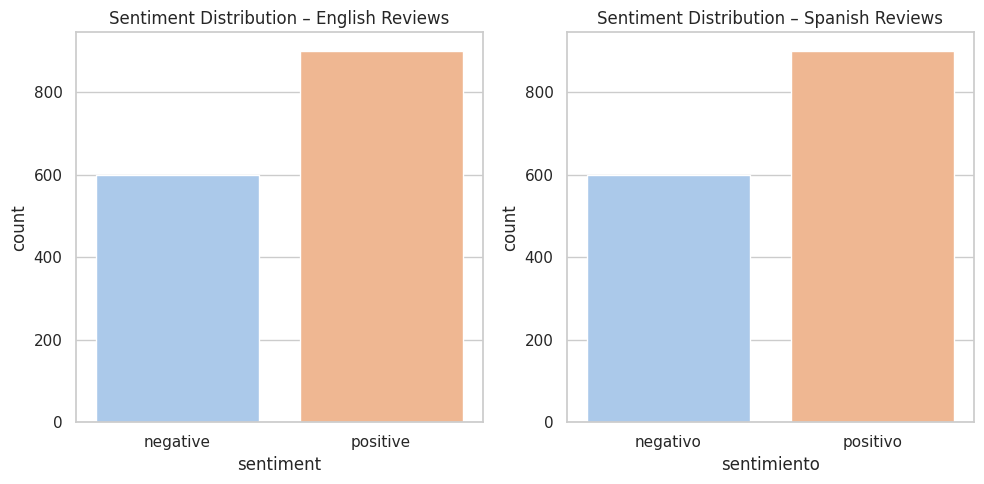

In [ ]:
#A. Sentiment Distribution (English vs Spanish)
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.countplot(x='sentiment', data=df, palette='pastel', ax=axes[0])
axes[0].set_title('Sentiment Distribution – English Reviews')

sns.countplot(x='sentimiento', data=df, palette='pastel', ax=axes[1])
axes[1].set_title('Sentiment Distribution – Spanish Reviews')

plt.tight_layout()
plt.show()


['review_en', 'review_en_clean', 'review_en_tokens', 'sentiment', 'review_en_wordcount', 'review_es', 'review_es_clean', 'review_es_tokens', 'review_es_wordcount', 'sentimiento']


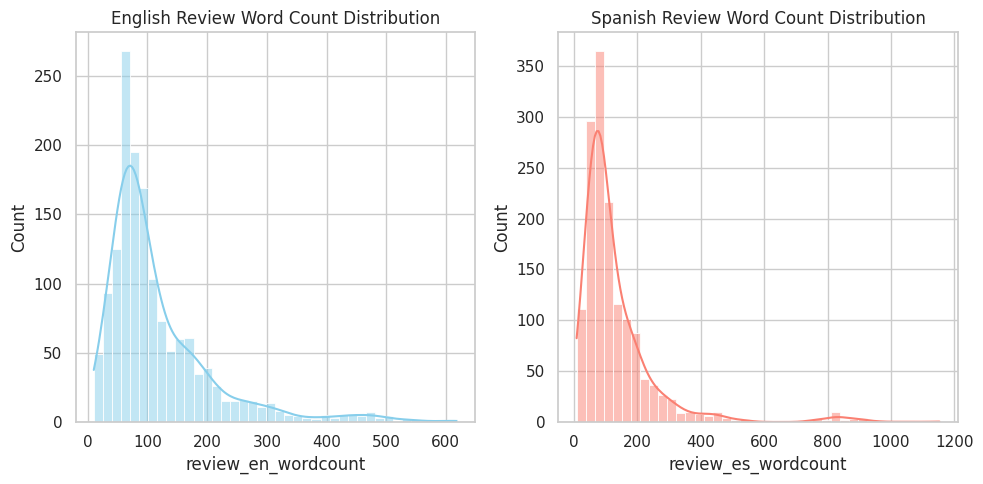

In [ ]:
#B. Review Length Distributions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

URL = "https://raw.githubusercontent.com/Eman-Nasr/multilingual-movie-reviews/main/multilingual_reviews_cleaned.csv"
df = pd.read_csv(URL)

print(df.columns.tolist())


fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.histplot(df['review_en_wordcount'], bins=40, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('English Review Word Count Distribution')

sns.histplot(df['review_es_wordcount'], bins=40, kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Spanish Review Word Count Distribution')

plt.tight_layout()
plt.show()
